<Figure size 2000x800 with 0 Axes>

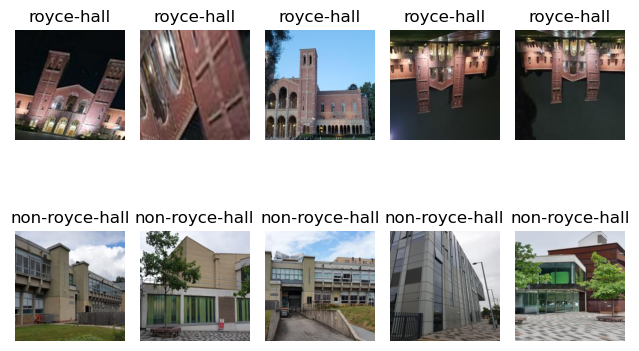

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

#define a function for plotting images 
def plot_sample_images(dataset_path, class_names, img_height=224, img_width=224, grid_rows=2, grid_cols=5):
    plt.figure(figsize=(20, 8))
    plt.figure().clear()
    for row in range(grid_rows):
        class_path = os.path.join(dataset_path, class_names[row])
        images = os.listdir(class_path)
        sampled_images = random.sample(images, grid_cols)

        for col in range(grid_cols):
            img_path = os.path.join(class_path, sampled_images[col])
            img = load_img(img_path, target_size=(img_height, img_width))
            plt.subplot(grid_rows, grid_cols, row * grid_cols + col + 1)
            plt.imshow(img)
            plt.title(class_names[row])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

dataset_path = 'dataset/train_set/'
class_names = ['royce-hall', 'non-royce-hall']  
plot_sample_images(dataset_path, class_names)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#defining the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


train_datagen = ImageDataGenerator(rescale=1./255) #rescale image

validation_datagen = ImageDataGenerator(rescale=1./255)#rescale image

train_generator = train_datagen.flow_from_directory(
        'dataset/train_set',  #path for train images
        target_size=(224, 224),  
        batch_size=32,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        'dataset/valid_set', #path for valid images
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n // train_generator.batch_size,
      epochs=20, #change with desired number of epocjs 
      validation_data=validation_generator,
      validation_steps=validation_generator.n // validation_generator.batch_size)


Found 209 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Epoch 1/20
6/6 [==============================] - 3s 429ms/step - loss: 1.4852 - accuracy: 0.5480 - val_loss: 0.7773 - val_accuracy: 0.5000
Epoch 2/20
6/6 [==============================] - 2s 411ms/step - loss: 0.6325 - accuracy: 0.7119 - val_loss: 0.6898 - val_accuracy: 0.4375
Epoch 3/20
6/6 [==============================] - 2s 417ms/step - loss: 0.5492 - accuracy: 0.7175 - val_loss: 0.6764 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 2s 395ms/step - loss: 0.4240 - accuracy: 0.7571 - val_loss: 0.4707 - val_accuracy: 0.6562
Epoch 5/20
6/6 [==============================] - 3s 491ms/step - loss: 0.2234 - accuracy: 0.9379 - val_loss: 0.1841 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 3s 402ms/step - loss: 0.1149 - accuracy: 0.9661 - val_loss: 1.3590 - val_accuracy: 0.5938
Epoch 7/20
6/6 [==============================] - 2s 411ms/step - loss: 0.1396 

In [3]:
#test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Found 36 images belonging to 2 classes.
2/2 [==============================] - 0s 17ms/step - loss: 0.0885 - accuracy: 0.9722
Test Loss: 0.08848119527101517, Test Accuracy: 0.9722222089767456


In [4]:
# import visualkeras
# from PIL import ImageFont

# font = ImageFont.load_default() # using comic sans is strictly prohibited!
# visualkeras.layered_view(model) .show() # font is optional!

In [5]:
#######Uncomment this to upload a file via path########

# import numpy as np
# from tensorflow.keras.preprocessing import image
# from IPython.display import display
# from PIL import Image
# import io

# def load_and_preprocess_image(image_path, target_size=(224, 224)):
#     """
#     Load an image file and preprocess it to be suitable for the model.

#     :param image_path: Path to the image file
#     :param target_size: The target size of the image (width, height)
#     :return: Preprocessed image
#     """
#     img = image.load_img(image_path, target_size=target_size)
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#     img_array /= 255.0  # Normalize to [0,1]
#     return img_array

# def predict_image_class(model, img_array, class_names):
#     """
#     Predict the class of an image using a trained model.

#     :param model: Trained Keras model
#     :param img_array: Preprocessed image array
#     :param class_names: List of class names
#     :return: Predicted class name
#     """
#     prediction = model.predict(img_array)
#     predicted_class = class_names[int(prediction[0] > 0.5)]  # Assuming binary classification
#     return predicted_class

# # Upload an image
# uploaded_image_path = input("Please enter the path of your image: ")

# # Assuming class names are 'positive' and 'negative'
# class_names = ['Royce Hall', 'Not Royce Hall']

# # Preprocess the image
# preprocessed_image = load_and_preprocess_image(uploaded_image_path)

# # Predict the class
# predicted_class = predict_image_class(model, preprocessed_image, class_names)
# print("Predicted class:", predicted_class)


In [6]:
# #saving the model
# model.save('model_1.h5')


In [7]:
# Checking the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [8]:
# Function to plot the lost history of the model
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.savefig("plot.png")
    plt.show()
    


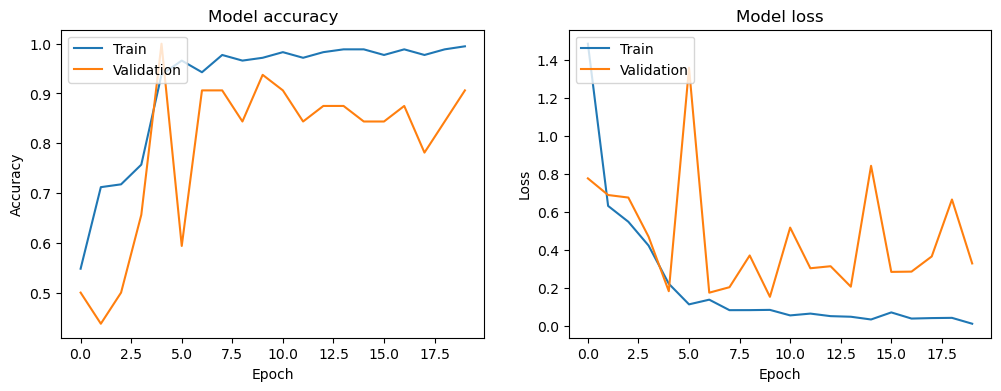

In [9]:
plot_history(history)

In [10]:
import pandas as pd

#converts history of the model into a dataframe
def history_to_dataframe(history):
    data = {
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy']
    }

    return pd.DataFrame(data)

In [11]:
df_loss = history_to_dataframe(history)
print(df_loss)

    Epoch  Training Loss  Validation Loss  Training Accuracy  \
0       1       1.485198         0.777291           0.548023   
1       2       0.632490         0.689794           0.711864   
2       3       0.549203         0.676442           0.717514   
3       4       0.424026         0.470711           0.757062   
4       5       0.223382         0.184093           0.937853   
5       6       0.114932         1.359042           0.966102   
6       7       0.139588         0.176380           0.942708   
7       8       0.084439         0.205156           0.977401   
8       9       0.084654         0.372011           0.966102   
9      10       0.085917         0.154555           0.971751   
10     11       0.056899         0.518499           0.983051   
11     12       0.066394         0.304770           0.971751   
12     13       0.052998         0.315415           0.983051   
13     14       0.049866         0.207920           0.988701   
14     15       0.035427         0.84348

In [12]:
#convert this to latex
latex_table = df_loss.to_latex(index=False, float_format="%.3f")

# Print the LaTeX tableprint(latex_table)

In [13]:
from tensorflow.keras.preprocessing import image

#generates the activation for a given image
def get_activations(model, img_path):

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Create a model that will return the outputs of each layer in the original model
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Get the activations
    activations = activation_model.predict(img_array)

    return activations

#plots the activation for a given layer
def plot_layer_activation(activation, layer_name):
    num_features = activation.shape[-1]
    size = activation.shape[1]
    num_cols = num_features // 16

    display_grid = np.zeros((size * num_cols, size * 16))

    for col in range(num_cols):
        for row in range(16):
            if col * 16 + row < num_features:
                channel_image = activation[0, :, :, col * 16 + row]
                # Post-process the feature
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    #plt.savefig(str(layer_name)+".png")
    plt.show()


1/1 [==============================] - 0s 60ms/step


/var/folders/5d/9xf2qmpj38d5hc4kn6sxqshh0000gn/T/ipykernel_75668/266215048.py:34: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/var/folders/5d/9xf2qmpj38d5hc4kn6sxqshh0000gn/T/ipykernel_75668/266215048.py:37: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


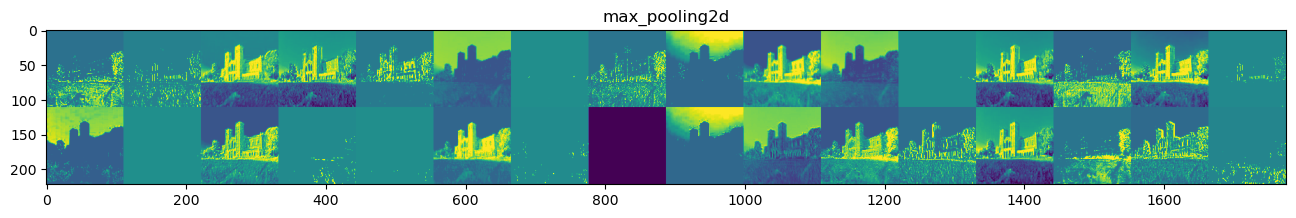

In [14]:
img_path = 'royce.jpeg'
layer_activation = get_activations(model, img_path)[1]
plot_layer_activation(layer_activation, model.layers[1].name)